In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy

In [2]:
from cov_3X2 import *
from fisher import *

In [49]:
import lsst_utils
reload(lsst_utils)
from lsst_utils import *

In [50]:
fig_home='./figures/'
fig_format='pdf'

In [51]:
def cosmo_w0_wa(cosmo=None,w0=-1,wa=0):
    attrs=['H0','Om0', 'Ode0','Tcmb0', 'Neff', 'm_nu', 'Ob0']
    args={}
    args['w0']=w0
    args['wa']=wa
    for a in attrs:
        args[a]=getattr(cosmo,a)
    cosmo_w=astropy.cosmology.w0waCDM(**args)
    return cosmo_w
cosmo_w0_wa(cosmo=cosmo)

w0waCDM(H0=67.7 km / (Mpc s), Om0=0.307, Ode0=0.691, w0=-1, wa=0, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [52]:
def cosmo_h_set(cosmo=None,cosmo_params={}):
    if cosmo_params['wa']!=0:
        cosmo=cosmo_w0_wa(cosmo=cosmo,w0=cosmo_params['w'],wa=cosmo_params['wa'])
    cosmo2=cosmo.clone(H0=cosmo_params['h']*100,
                        Om0=cosmo_params['Om'],
                       Ob0=cosmo_params['Omb'],
#                        Odm0=cosmo_params['Omd'],
#                        Ok0=cosmo_params['Omk'],
#                        w=cosmo_params['w'],
                       m_nu=[0,0,cosmo_params['mnu']]*units.eV
                    )

In [53]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False,
               cov_3X2_kwargs={},zs_bins_kwargs={},ell_bin_kwargs={}):
    zs_bins=lsst_source_tomo_bins(**zs_bins_kwargs)
    l0,l_bins,l=get_cl_ells(**ell_bin_kwargs)
    kappa_class=cov_3X2(l=l0,l_bins=l_bins,zs_bins=zs_bins,**cov_3X2_kwargs)
    
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    cosmo_h=kappa_class.Ang_PS.PS.cosmo_h.clone()
    
    cl0G=kappa_class.cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            if x0==0:
                x_vars[p]=np.logspace(-3,-2,Nx)
            x_vars[p]*=np.sign(cosmo_fid[p])
            x_grad=np.gradient(np.log(x_vars[p]))
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
            if x0==0:
                x_vars[p]=Dx-1
            x_grad=np.gradient(x_vars[p])
        
        models[p]={}
        covs[p]={}
        print(p,x_vars[p])
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
         
            cosmo_t[p]=x_vars[p][i]
            
            if p=='s8':
                s80=cosmo_fid['s8']
                cosmo_t['As']*=(cosmo_t['s8']/s80)**2
                kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
                kappa_class.Ang_PS.PS.pk=None
                x_vars[p][i]=kappa_class.Ang_PS.PS.s8
#                 print(x_vars[p][i],s80,cosmo_t['s8'])
            cosmo_h2=cosmo_h_set(cosmo=cosmo,cosmo_params=cosmo_t)
            cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t,cosmo_h=cosmo_h2)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
            covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
            
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grad
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grad
#             print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            
            if do_cov:
#                 print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['cov_inv']=cov_inv
    out['model']=models[p][1]
    out['x_vars']=x_vars
    kappa_class.do_cov=do_cov0
    return out

In [42]:
def get_cl_ells(lmax_cl=5000,lmin_cl=2,Nl_bins=40):
    l0=np.arange(lmin_cl,lmax_cl)

    lmin_cl_Bins=lmin_cl+10
    lmax_cl_Bins=lmax_cl-10
    l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
    

    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    return l0,l_bins,l


In [38]:
#setup parameters
l0,l_bins,l=get_cl_ells()
lb=0.5*(l_bins[1:]+l_bins[:-1])

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [9]:
zs_bins=lsst_source_tomo_bins()

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

sigma_gamma=0.26
area=14000
f_sky=area*d2r**2/4/np.pi

ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [10]:
f_sky

0.3393695767766752

In [61]:
cov_3X2_kwargs={'do_cov':do_cov,'bin_cl':bin_cl,'zg_bins':None,#'l':l0,'l_bins':l_bins,
            'SSV_cov':SSV_cov,'tidal_SSV_cov':tidal_SSV,'do_xi':False,'use_window':use_window,'f_sky':f_sky,'sigma_gamma':sigma_gamma,
            'do_sample_variance':do_sample_variance,'power_spectra_kwargs':{'pk_func':'class_pk'},
            'bin_xi':bin_xi}
zs_bins_kwargs={'zmin':0.3,'zmax':3,'ns0':26,'nbins':3,'z_sigma':0.05,'z_sigma_power':1}
ell_bin_kwargs={'lmax_cl':5000,'lmin_cl':2,'Nl_bins':40}

In [12]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zsigma={}
z_sigs=np.logspace(-2,0,5)
for zs in z_sigs:
    zs_bins_kwargs['z_sigma']=zs
    fishes_zsigma[zs]=fisher_calc(params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma']=0.05

ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:02:48 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:

0.01 177.7859258564627
0.03162277660168379 175.8195905329173
0.1 160.896562808602
0.31622776601683794 109.85423770951529
1.0 48.00763782411372


03:02:48 DEBUG:findfont: Matching :family=STIXSizeFourSym:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXSizeFourSym ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :family=STIXSizeFiveSym:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXSizeFiveSym ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :family=cmsy10:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to cmsy10 ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :family=cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to cmr10 ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf') with score of 0.050000
03:02:48 DEBUG:findfont: Matching :fa

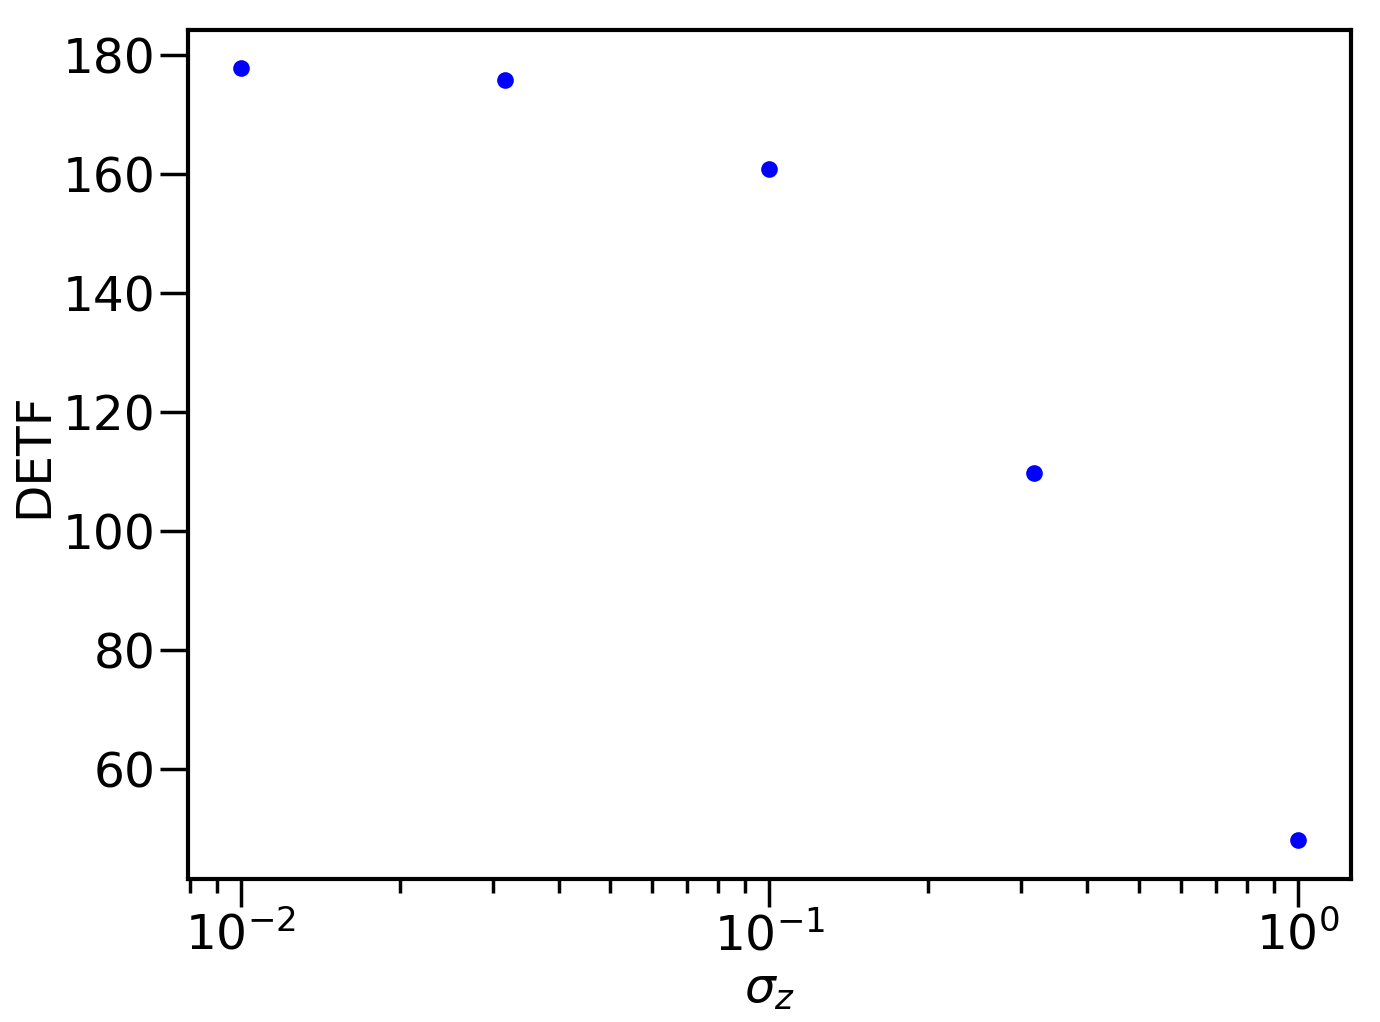

In [13]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zsigma.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$')
ax.set_ylabel('DETF')
fname='sigmaz_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)
# yscale('log')

In [64]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zsigma_pow={}
z_pow=[0,1,2]
for zp in z_pow:
    zs_bins_kwargs['z_sigma_power']=zp
    fishes_zsigma_pow[zp]=fisher_calc(params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                  zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['z_sigma_power']=1

ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
04:50:34 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


0 176.18390104544818
1 172.97133088720457
2 158.8616015624055


04:50:35 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
04:50:35 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
04:50:35 DEBUG:Writing TrueType font.
04:50:35 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
04:50:35 DEBUG:Writing TrueType font.
04:50:35 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
04:50:35 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
04:50:36 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
04:50:36 DEBUG:Writing TrueType font.
04:50:36 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
04:50:36 DEBUG:Writing TrueType font.


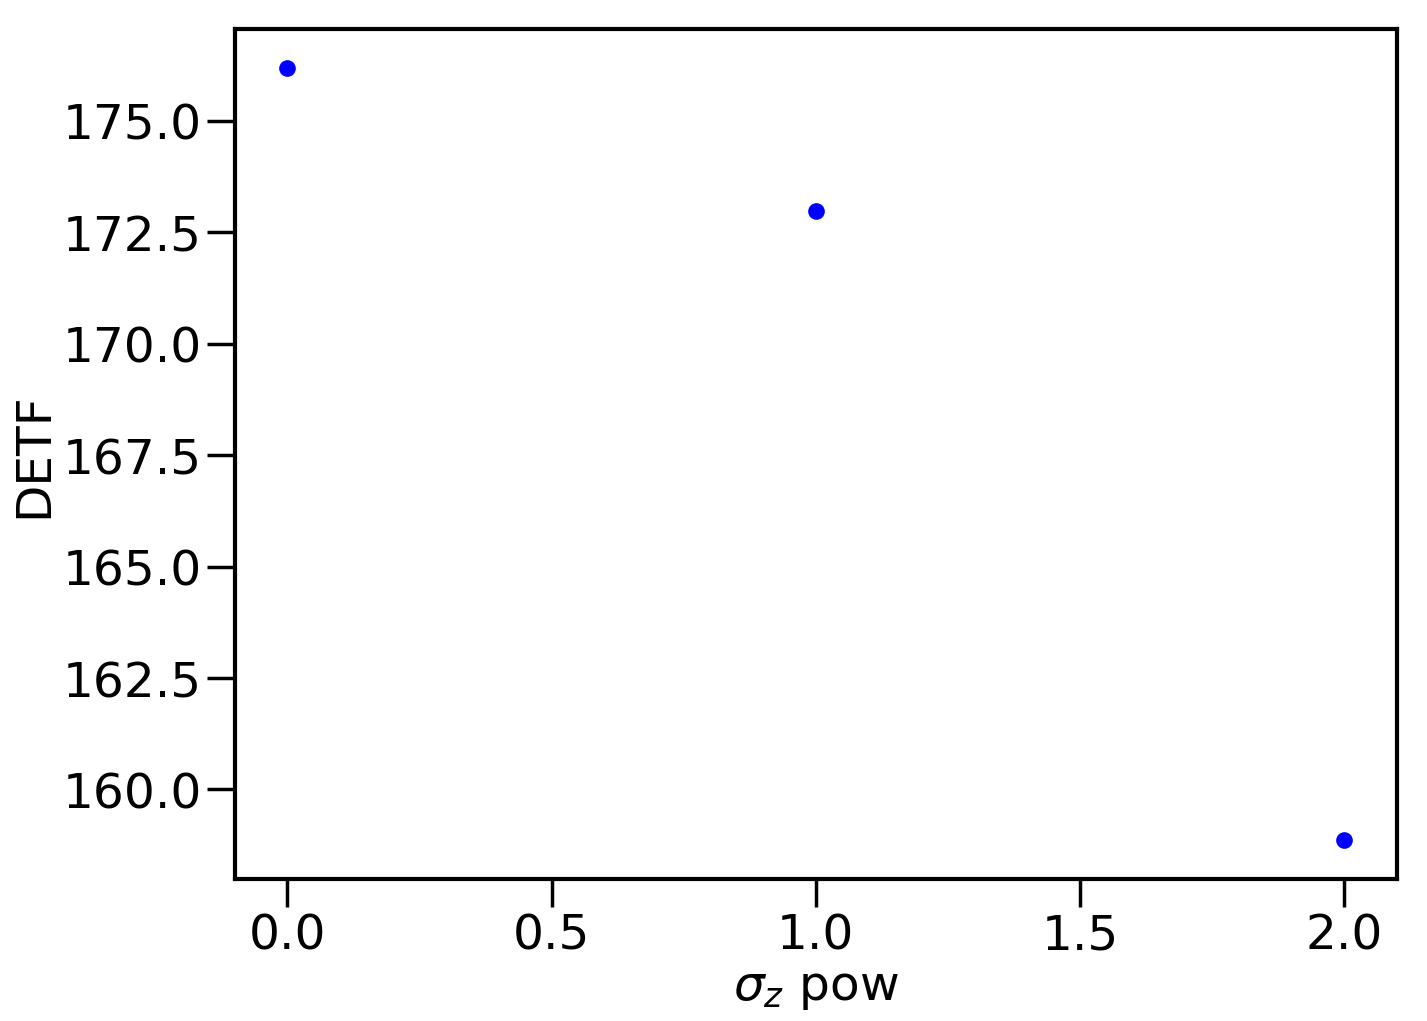

In [65]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zsigma_pow.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zsigma_pow[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# ax.set_xscale('log')
ax.set_xlabel('$\sigma_z$ pow')
ax.set_ylabel('DETF')
fname='sigmaz_pow_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)
# yscale('log')

In [24]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zmax={}
z_ms=[3] #[1,1.5,2,3]
for zm in z_ms:
    zs_bins_kwargs['zmax']=zm
    fishes_zmax[zm]=fisher_calc(params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['zmax']=3

ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]


In [25]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_zmin={}
z_ms=[0.1,0.3,0.5]
for zm in z_ms:
    zs_bins_kwargs['zmin']=zm
    fishes_zmin[zm]=fisher_calc(params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
zs_bins_kwargs['zmin']=0.3

ns0:  25.213163099781298


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  20.2996223381013
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:25:53 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


1 2.881342183191316
1.5 31.164215234899768
2 86.62744097736866
3 172.97133088720457


03:25:53 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
03:25:53 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
03:25:53 DEBUG:Writing TrueType font.
03:25:53 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:25:53 DEBUG:Writing TrueType font.
03:25:53 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
03:25:53 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
03:25:54 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
03:25:54 DEBUG:Writing TrueType font.
03:25:54 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:25:54 DEBUG:Writing TrueType font.


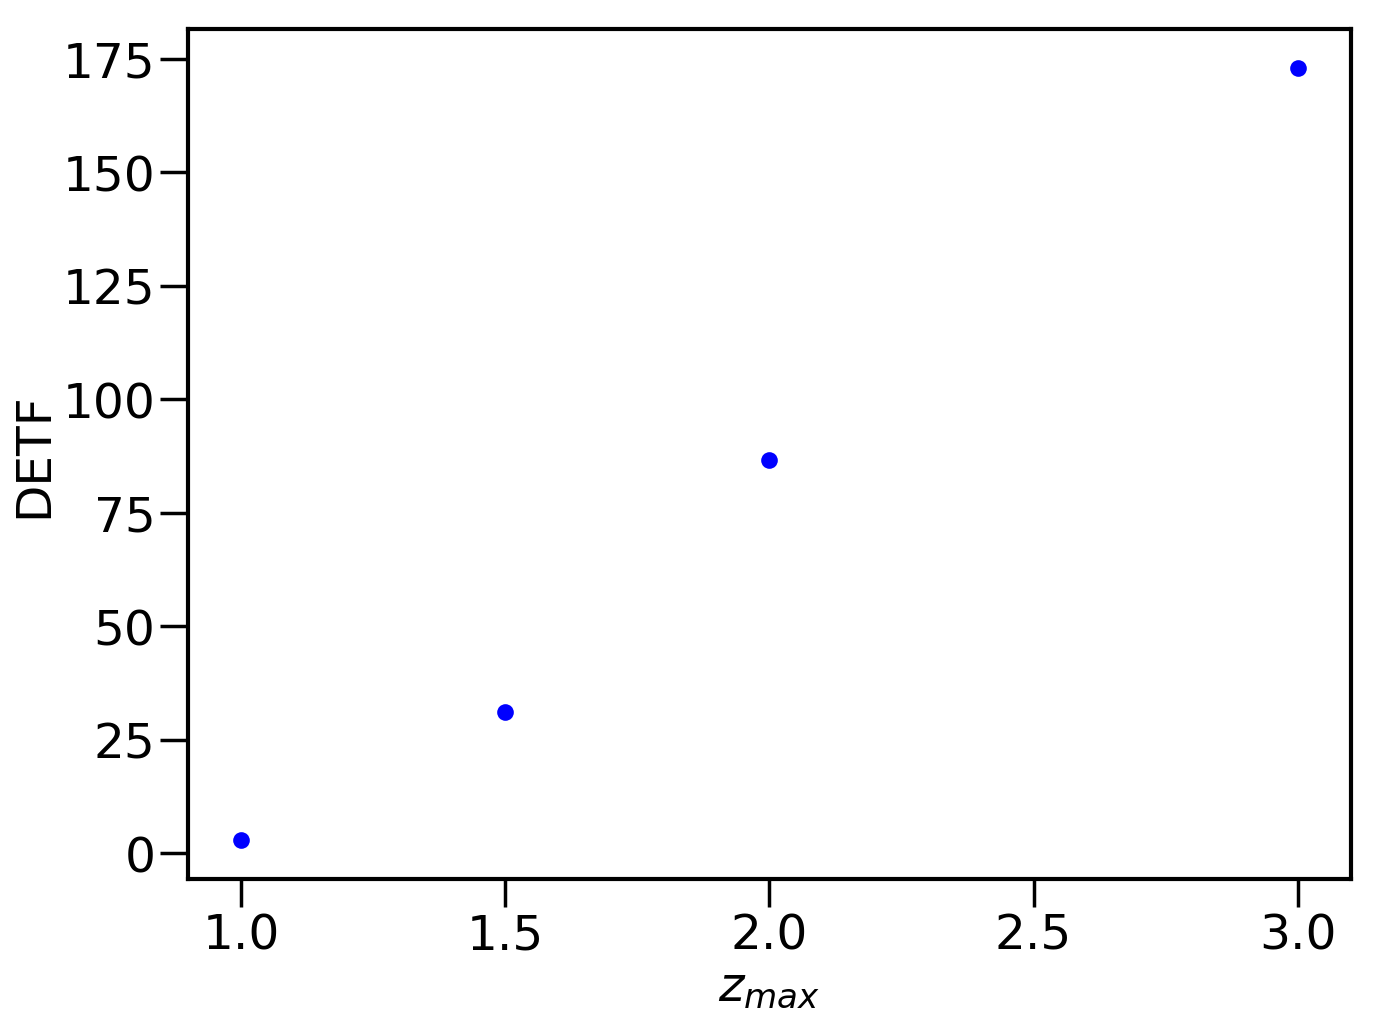

In [26]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zmax.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zmax[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$z_{max}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='zmax_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:25:55 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


0.1 181.42994271972887
0.3 172.97133088720457
0.5 138.2148895021703


03:25:55 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
03:25:56 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
03:25:56 DEBUG:Writing TrueType font.
03:25:56 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:25:56 DEBUG:Writing TrueType font.
03:25:56 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
03:25:56 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
03:25:56 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
03:25:56 DEBUG:Writing TrueType font.
03:25:56 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:25:56 DEBUG:Writing TrueType font.


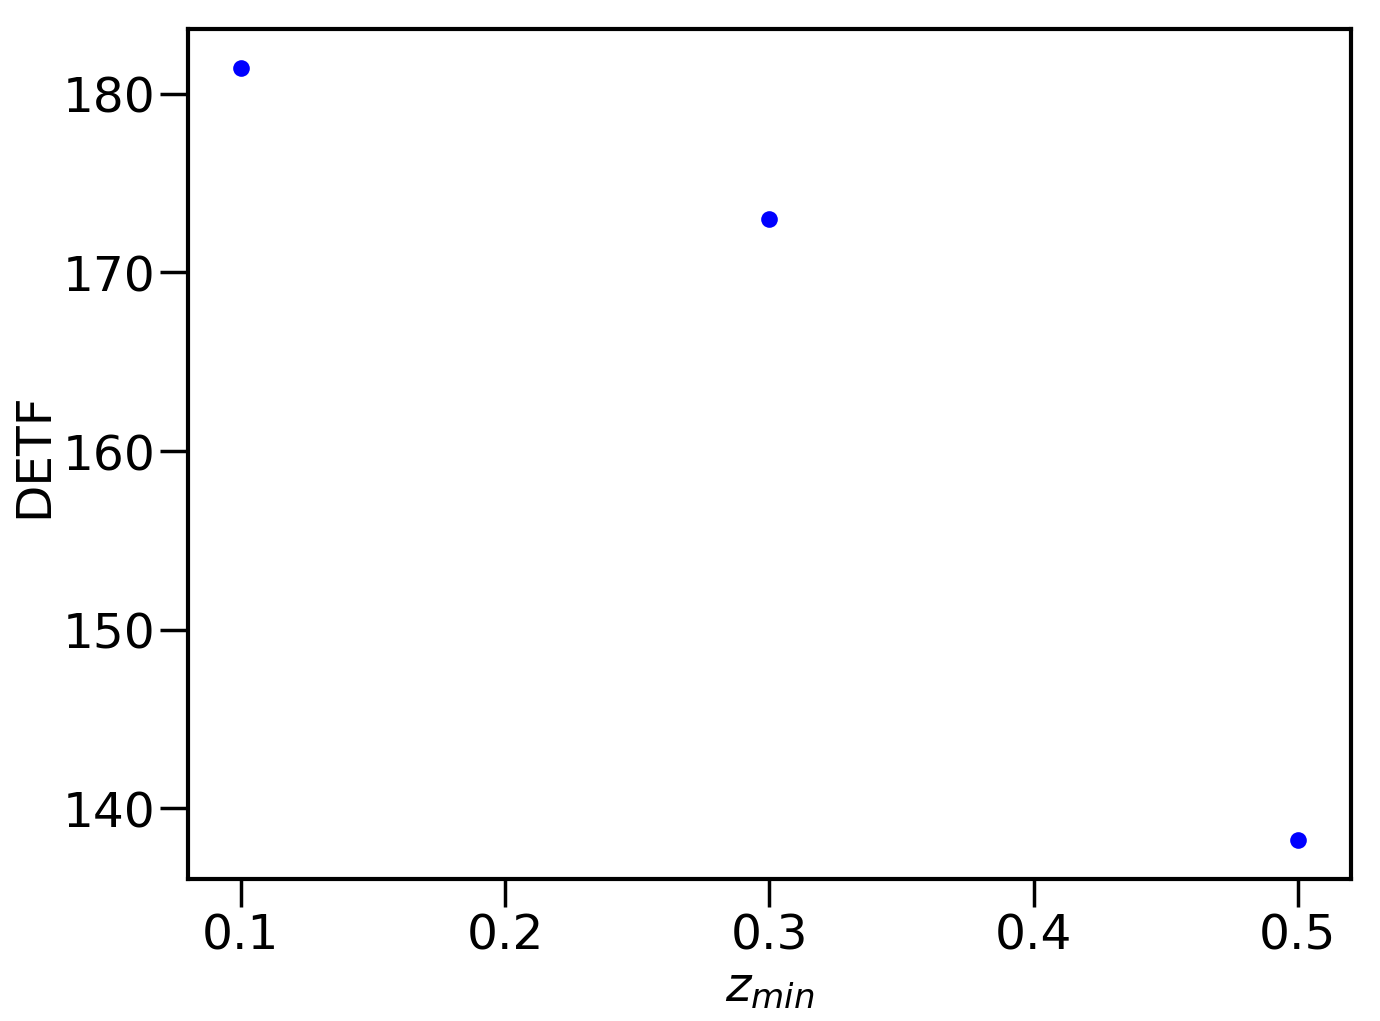

In [27]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_zmin.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_zmin[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$z_{min}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='zmin_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [33]:
zs_bins_kwargs

{'zmin': 0.3, 'zmax': 3, 'ns0': 26, 'nbins': 3, 'z_sigma': 0.01}

In [43]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_ell={}
ells=[1000,2000,5000]
for ell in ells:
    ell_bin_kwargs['lmax_cl']=ell
    fishes_ell[ell]=fisher_calc(params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,
                                zs_bins_kwargs=zs_bins_kwargs,ell_bin_kwargs=ell_bin_kwargs)
ell_bin_kwargs['lmax_cl']=5000

ns0:  23.376047655582575
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 2

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
[   2    3    4 ... 1997 1998 1999] [  12   13   15   17   20   23   26   30   34   39   44   50   57   65
   75   85   97  111  126  144  164  188  214  244  278  317  362  412
  470  536  611  697  795  906 1033 1178 1343 1531 1745 1989]
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
[   2    3    4 ... 4997 4998 4999] [  12   14   16   19   22   25   30   35   41   48   56   65   76   89
  104  122  142  166  194  226  264  308  360  420  490  572  668  780
  910 1063 1240 1448 1690 1973 2303 2688 3137 3662 4275 4989]
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:43:10 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


1000 14.503396369317056
2000 48.9026534698494
5000 177.7859258564627


03:43:10 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
03:43:11 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
03:43:11 DEBUG:Writing TrueType font.
03:43:11 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:43:11 DEBUG:Writing TrueType font.
03:43:11 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
03:43:11 DEBUG:Assigning font /b'F2' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
03:43:12 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
03:43:12 DEBUG:Writing TrueType font.
03:43:12 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:43:12 DEBUG:Writing TrueType font.


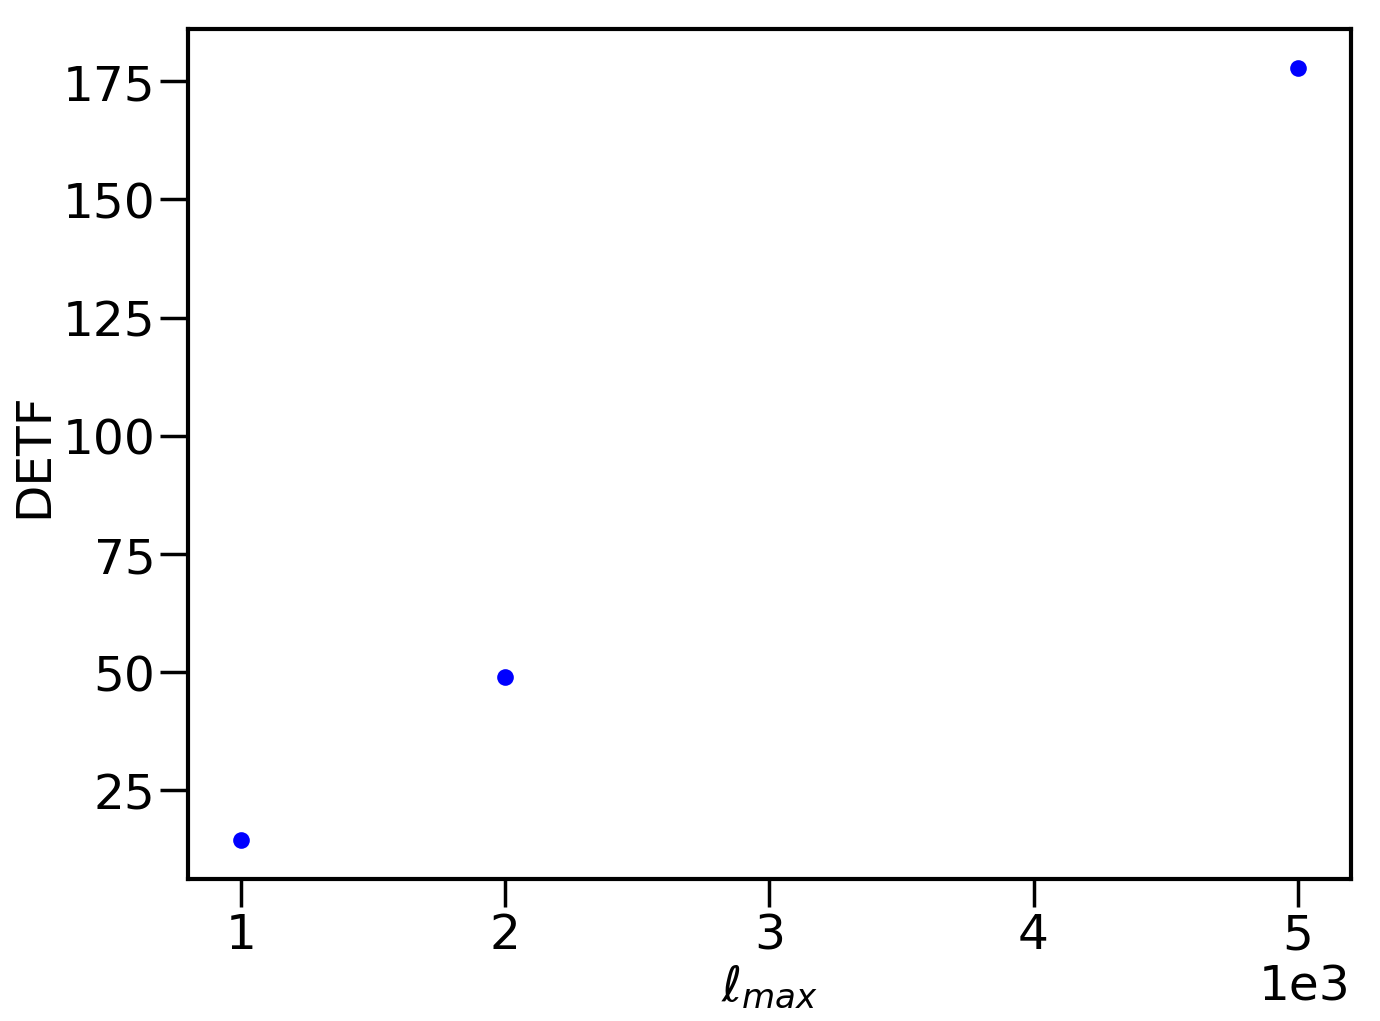

In [44]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_ell.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_ell[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
# ax.set_xlim(1.5,11)
# ax.set_ylim(120,145)
ax.set_xlabel('$\ell_{max}$')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='ellmax_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]
ns0:  23.376047655582575
As [2.178e-09 2.200e-09 2.222e-09]
Om [0.304425 0.3075   0.310575]
w [-0.99 -1.   -1.01]
wa [-0.01  0.    0.01]


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
04:13:33 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


2 145.8041173418535
10 196.43995082770692
1 4.76945970379347
5 188.8159075237156
3 172.97133088720457


04:13:34 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
04:13:34 DEBUG:Writing TrueType font.
04:13:34 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
04:13:34 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
04:13:34 DEBUG:Writing TrueType font.


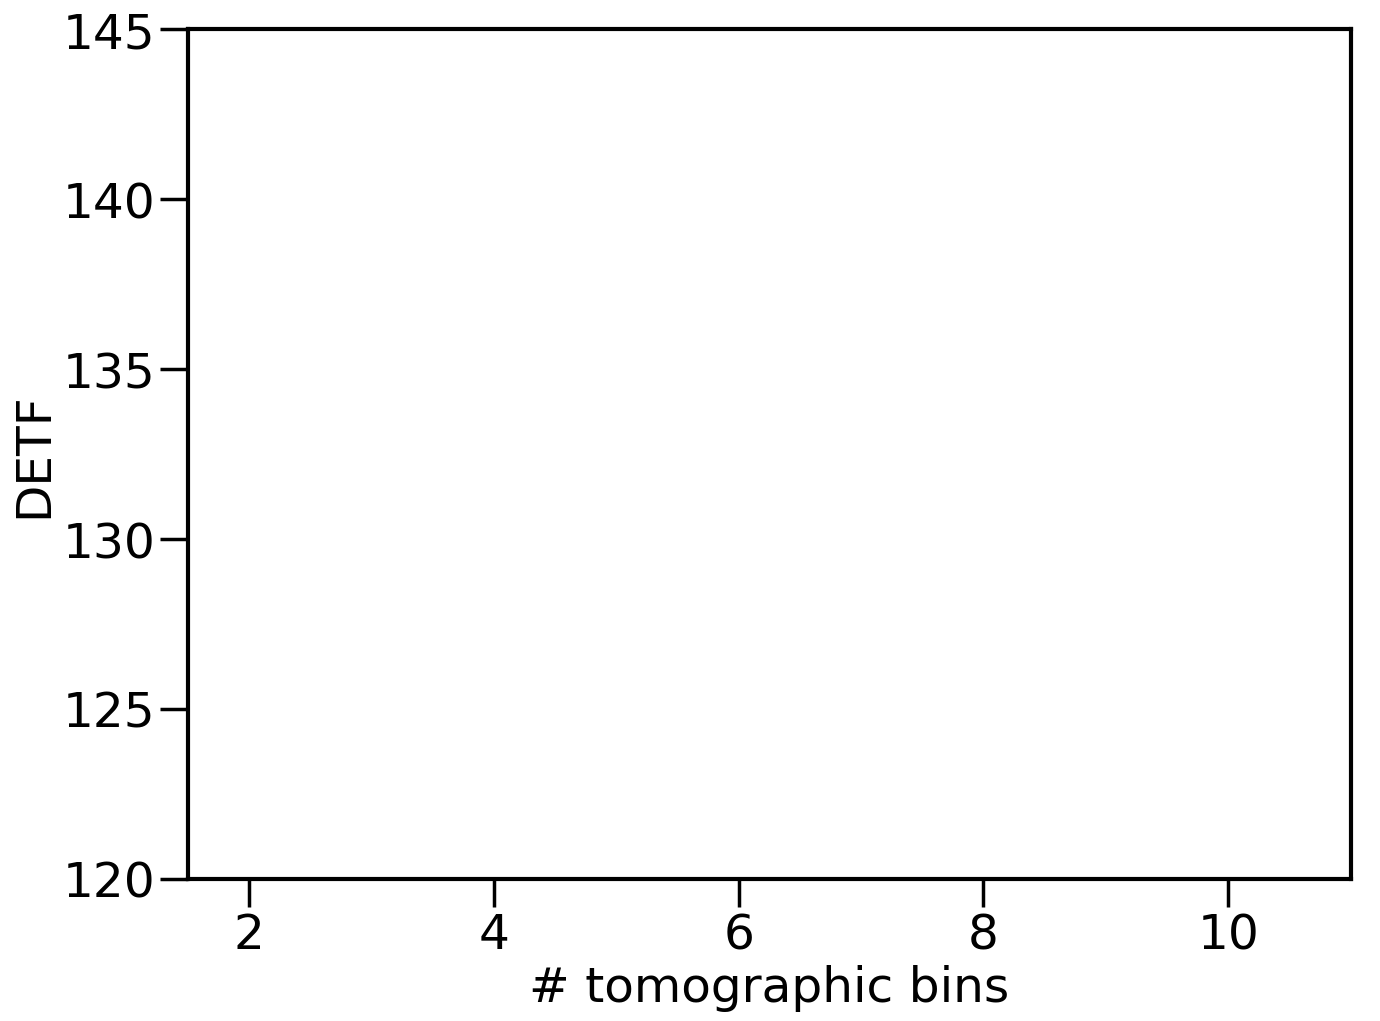

In [46]:
p=np.atleast_1d(['As','Om','w','wa'])
#p=np.atleast_1d(['s8'])
fishes_nb={}
zs_bins_kwargs['z_sigma']=0.05
nbs=[2,10,1,5,3]#10
# nbs=np.arange(10)+1
for nb in nbs:
    zs_bins_kwargs['nbins']=nb
    fishes_nb[nb]=fisher_calc(params=p,do_cov=False,do_log=False,cov_3X2_kwargs=cov_3X2_kwargs,zs_bins_kwargs=zs_bins_kwargs)
zs_bins_kwargs['nbins']=3

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
04:31:20 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


2 145.8041173418535
10 196.43995082770692
1 4.76945970379347
5 188.8159075237156
3 172.97133088720457


04:31:21 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
04:31:21 DEBUG:Writing TrueType font.
04:31:21 DEBUG:Assigning font /b'F1' = '/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
04:31:22 DEBUG:Embedding font /usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
04:31:22 DEBUG:Writing TrueType font.


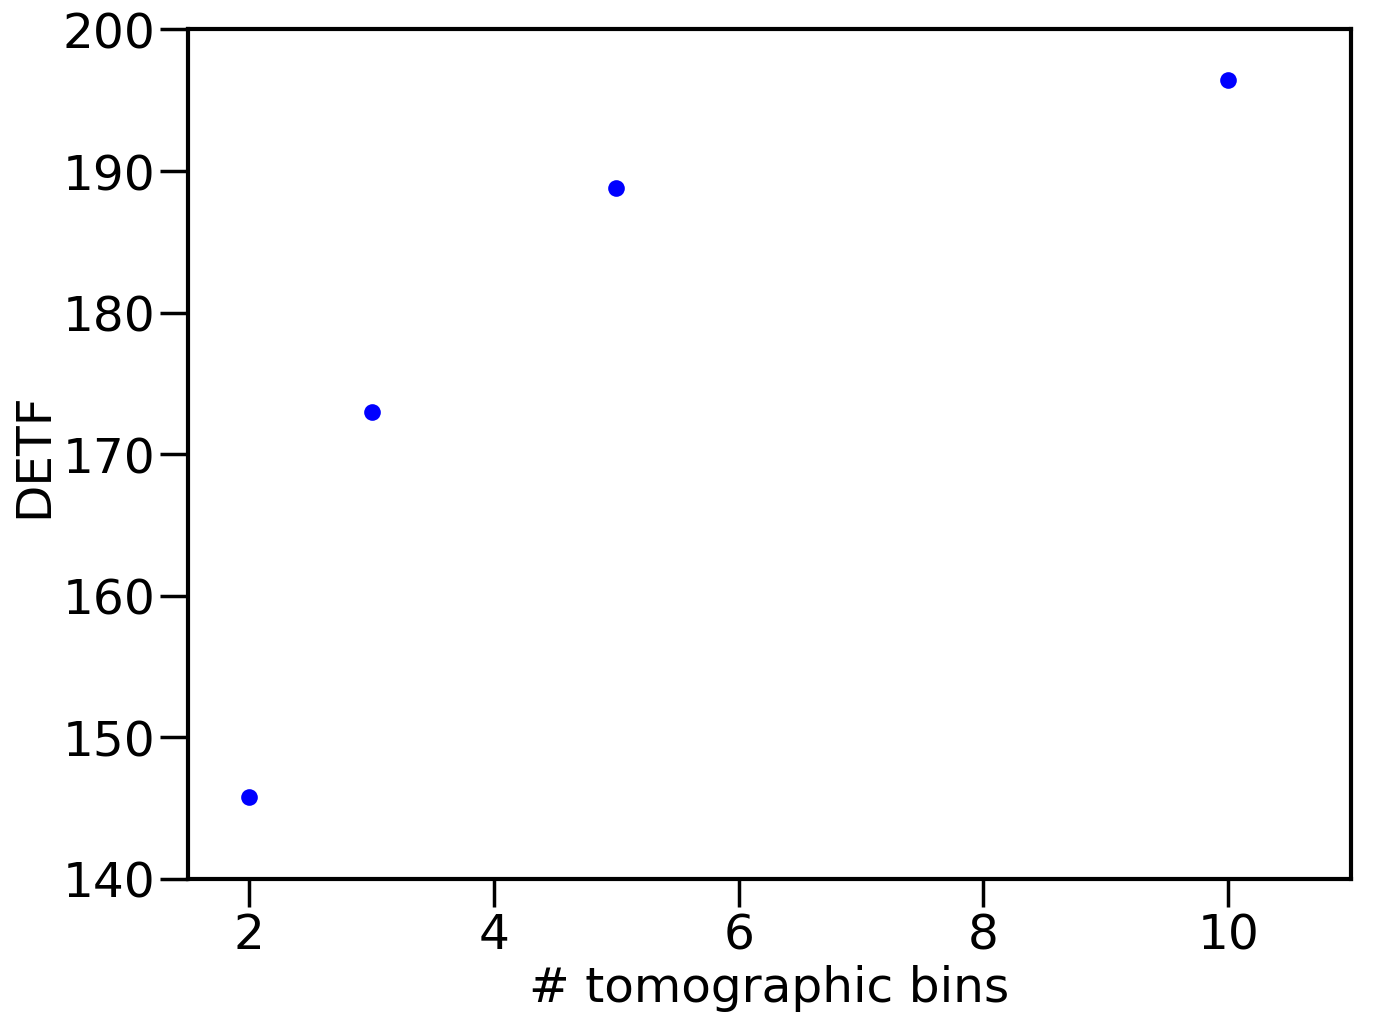

In [48]:
fig, ax = subplots(1,1, figsize=(15,11.25))
for k in list(fishes_nb.keys()):
    sn=1./np.sqrt(np.linalg.det(fishes_nb[k]['cov_p'][-2:,-2:]))
    print(k,sn)
    ax.plot(k,sn,'bo')
# xscale('log')
ax.set_xlim(1.5,11)
ax.set_ylim(140,200)
ax.set_xlabel('# tomographic bins')
ax.set_ylabel('DETF')
# ax.set_yscale('log')
fname='nbins_detf'
fig.savefig(fig_home+fname+'.'+fig_format,bbox_inches='tight',format=fig_format)

In [ ]:
1./np.sqrt(np.linalg.det(fish['cov_p'][-2:,-2:]))

In [ ]:
fish['error']

In [ ]:
fish['error']

In [ ]:
m=fish['model']
ci=fish['cov_inv']
np.sqrt(np.dot(m,np.dot(ci,m)))

In [ ]:
np.linalg.eig(fish['cov_p'])